In [76]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import neurokit2 as nk
import warnings
warnings.filterwarnings('ignore')

# set global parameters
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
# mpl.style.use("ggplot") # selecting the style sheet

from lists import dyads, num_dyads, participants, num_participants

In [77]:
# Set sampling rate
sampling_rate = 1000
print("Sampling rate:", sampling_rate)

# Set conditions
condition = ["sit","gaze"]
print("Conditions:", condition)

# Show number of participants
print("Participants:", num_participants)

# Show number of dyads
print("Dyads:", num_dyads)

Sampling rate: 1000
Conditions: ['sit', 'gaze']
Participants: 8
Dyads: 4


In [78]:
xlim1 = 10*sampling_rate
xlim2 = 14*sampling_rate

dpi = 96
figsize = 6, 3

mpl.rcParams["legend.frameon"] = True
mpl.rcParams["legend.fancybox"] = False
mpl.rcParams["legend.framealpha"] = 0.9
mpl.rcParams["legend.edgecolor"] = "darkgrey"

c = 1  # condition
d = 2  # dyad -> only even numbers
p = 6  # person

In [79]:
# Load ECG-data as list and downsaples to 1000 Hz
ecg_raw_2000hz = np.load(f"data/ecg_raw/ecg_raw_{condition[c]}.npy")
ecg_raw = []

for i in range(num_participants):
    ecg_raw.append(ecg_raw_2000hz[i][::2])  # change sampling rate to 1000 Hz

In [80]:
# Analyze raw ECG data
ecg_process = []
ecg = []
for i in range(num_participants):
    ecg_process_temp, info_temp = nk.ecg_process(
        ecg_raw[i], sampling_rate=sampling_rate)
    ecg_process.append(ecg_process_temp)
    ecg.append(ecg_process[i]["ECG_Clean"])

ecg_process[p]

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,0.005798,0.007556,74.964076,0.97369,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,0.006714,0.008626,74.964076,0.97369,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,0.006561,0.009700,74.964076,0.97369,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,0.006409,0.010784,74.964076,0.97369,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,0.008087,0.011885,74.964076,0.97369,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,-0.030365,-0.002425,86.830680,0.27100,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
299996,-0.029602,-0.002181,86.830680,0.27100,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
299997,-0.028076,-0.001933,86.830680,0.27100,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
299998,-0.027924,-0.001687,86.830680,0.27100,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


In [81]:
# Calculate all data
from math import pi, cos
rpeaks = []
ibi = []
start = []
ibi_ts = []

lim1 = []
lim2 = []

ibi_ts_ip = []
ibi_ts_ip_1hz = []
ibi_ts_ip_win = []

ibi_all = []
ibi_ts_ip_1hz_all = []
ibi_ts_ip_win_all = []

data = []

# Get binary R-peak time series
for i in range(num_participants):
    rpeaks.append(ecg_process[i]["ECG_R_Peaks"])  # binary data

# Calculate IBIs
def get_ibi(rpeaks):
    start = np.squeeze(np.array(np.where(rpeaks == 1)))
    ibi = []
    for i in range(len((start))):
        if i > 0:  # skip first iteration
            ibi.append(start[i]-start[i-1])
    # start[1], not start[0], to get the true starting point for the IBI-intervals (=differences of start)
    return ibi, start[1]

for i in range(num_participants):
    ibi_temp, start_temp = get_ibi(rpeaks[i])
    ibi.append(ibi_temp)
    start.append(start_temp)

# Calculate IBI data as time series (Tachogram)
def get_ibi_timeseries(rpeaks, ibi, start, begin_at_0):
    ibi_ts = rpeaks[start:]
    ibi_ts = np.array(ibi_ts)

    j = 0
    for i in range(len(ibi_ts)):
        if ibi_ts[i] == 1:
            ibi_ts[i] = ibi[j]
            j = j+1
    ibi_ts = pd.Series(ibi_ts)
    # add zeros for true lenght of the time series
    if begin_at_0 == "True":
        intro = pd.Series(np.zeros(start))
        ibi_ts = pd.concat([intro, ibi_ts], ignore_index=True)
    return ibi_ts

for i in range(num_participants):
    ibi_ts.append(get_ibi_timeseries(rpeaks[i], ibi[i], start[i], "True"))

# Calculate the limits to plot IBIs within the time interval from xlim1 to xlim2
def get_ibi_limits(ibi, ibi_ts, xlim1, xlim2):
    lim1_time = np.argmax(ibi_ts[xlim1:xlim2] > 0) + xlim1
    lim2_time = xlim2 - np.argmax(ibi_ts[xlim2:xlim1:-1] > 0)

    lim1 = ibi.index(ibi_ts[lim1_time])
    lim2 = ibi.index(ibi_ts[lim2_time])

    return lim1, lim2

for i in range(num_participants):
    lim1_temp, lim2_temp = get_ibi_limits(
        ibi[i], ibi_ts[i], xlim1=xlim1, xlim2=xlim2)
    lim1.append(lim1_temp)
    lim2.append(lim2_temp)

# Imputate IBIs
def get_ibi_timeseries_interpolated(ibi_ts):
    ibi_ts_ip = ibi_ts.replace(0, np.nan, inplace=False)
    ibi_ts_ip = ibi_ts_ip.interpolate(
        method='linear', axis=0, limit=None, inplace=False)
    return ibi_ts_ip

for i in range(num_participants):
    ibi_ts_ip.append(get_ibi_timeseries_interpolated(ibi_ts[i]))

# Resampling at 1 Hz with rolling windows
def get_ibi_timeseries_interpolated_window(ibi_ts_ip):
    ibi_ts_ip_win = ibi_ts_ip.rolling(sampling_rate, center=True).mean()
    ibi_ts_ip_win = ibi_ts_ip_win.iloc[::sampling_rate]
    return ibi_ts_ip_win

ibi_ts_ip_win = []
for i in range(num_participants):
    ibi_ts_ip_win.append(get_ibi_timeseries_interpolated_window(ibi_ts_ip[i]))

# Resampling imputeted IBI at 1 Hz
for i in range(num_participants):
    ibi_ts_ip_1hz.append(ibi_ts_ip[i][::sampling_rate])

# Prepare data for violin plot
def flatten(nested_list):
    list_of_lists = []
    for item in nested_list:
        list_of_lists.extend(item)
    return list_of_lists

ibi_all = flatten(ibi)

for i in range(num_participants):
    ibi_ts_ip_1hz_all.append(np.array(ibi_ts_ip_1hz[i].dropna()))
ibi_ts_ip_1hz_all = flatten(ibi_ts_ip_1hz_all)

for i in range(num_participants):
    ibi_ts_ip_win_all.append(np.array(ibi_ts_ip_win[i].dropna()))
ibi_ts_ip_win_all = flatten(ibi_ts_ip_win_all)

# Cosine interpolation
def cosine(x, x1, x2):
    T = x2-x1
    val = 0.5 * cos(2.0 * pi * (x - x1) / T)
    return val

def get_rpeaks_cosine_interpolation(rpeaks):
    rpeaks_idx = [i for i, x in enumerate(rpeaks) if x == 1]
    rpeaks_cip = [np.nan]*rpeaks_idx[0]
    for i in range(len(rpeaks_idx)):
        if i == len(rpeaks_idx)-1:
            break
        x1 = rpeaks_idx[i]
        x2 = rpeaks_idx[i+1]
        T = x2-x1
        def f(x): return cosine(x, x1, x2)
        x = np.linspace(x1, x2, T)
        y = [f(x) for x in x]

        rpeaks_cip = rpeaks_cip + y
    rpeaks_cip = rpeaks_cip + [np.nan]*(len(rpeaks)-rpeaks_idx[-1])
    return rpeaks_cip  # keep in mind there are nans at the start and end

for i in range(num_participants):
    data.append(get_rpeaks_cosine_interpolation(rpeaks[i]))

# Normalize data
def get_normalized_df(df):
    normalized_df = (df-df.min())/(df.max()-df.min())
    return normalized_df

815.0
1
0.5
300000
2938 2384 2380
0.9992445196691971
30972.0 23572.583728796737 23595.461400332406


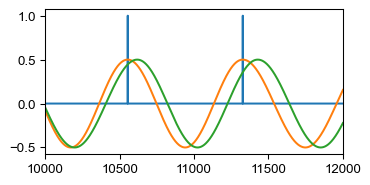

In [82]:
# Sanity checks
rpeaks_idx = []
for i in range(num_participants):
    rpeaks_idx.append([i for i, x in enumerate(rpeaks[p]) if x == 1])

q = 200
print(ibi_ts[p][rpeaks_idx[p][q]])
print(rpeaks[p][rpeaks_idx[p][q]])
print(data[p][rpeaks_idx[p][q]])

fig = plt.figure(figsize=(4, 2), dpi=96)
plt.xlim(10000, 12000)
plt.plot(rpeaks[p])
plt.plot(data[p])
if p+1 < num_participants:
    plt.plot(data[p+1])

print(len(data[p]))  # 300.000

print(len(ibi_all), len(ibi_ts_ip_1hz_all), len(ibi_ts_ip_win_all))

# Comparision with data input for LSTM model (at 50 Hz)
print(np.corrcoef(data[p][2000:298000:20], np.load(f"data/data_{condition[c]}.npy")[p])[0, 1])

# Checksum for IBI and imputated IBI
print(sum(ibi_ts[p][9000:40000]), sum(ibi_ts_ip_win[p][9:40]), sum(ibi_ts_ip_1hz[p][9:40]))

Number of R-peaks in plot: 6 5


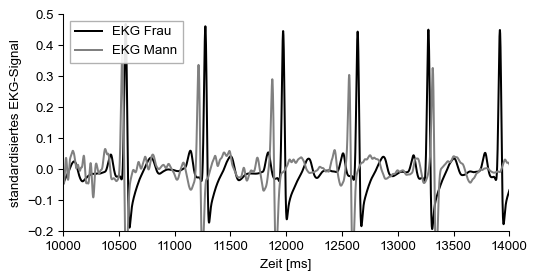

In [83]:
# Plot cleaned ECG data for a dyad
d=4
fig = plt.figure(figsize=figsize, dpi=dpi)

plt.xlim(xlim1, xlim2)
plt.margins(x=0)
plt.ylim(-0.2,0.5)

# plt.title("EKG-Signal einer Dyade")
plt.xlabel('Zeit [ms]')
plt.ylabel('standardisiertes EKG-Signal')

plt.plot(ecg[d], color="black", label="EKG Frau")
plt.plot(ecg[d+1], color="grey", label="EKG Mann")
sns.despine()
plt.legend(loc="upper left")
print("Number of R-peaks in plot:",
      sum(rpeaks[d][xlim1:xlim2]), sum(rpeaks[d+1][xlim1:xlim2]))

plt.savefig("plots/ecg_dyad.png", dpi=512)

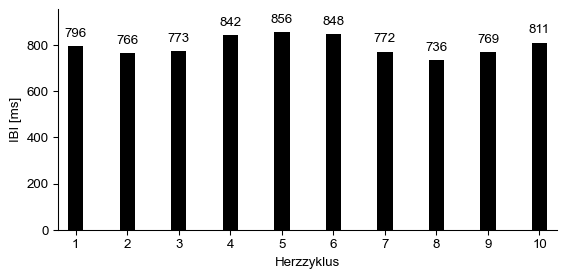

In [84]:
#  Plot tachogramm for IBI-series
ibi_plot = ibi[p][10:20]
fig = plt.figure(figsize=figsize, dpi=dpi)

# mpl.rcParams.update({'font.size': 11})

plt.margins(x=0.02)
plt.ylim(0,max(ibi[p][10:20])+100)

plt.xlabel('Herzzyklus')
plt.ylabel('IBI [ms]')
x = range(1,11) # label locations
plt.xticks(x)

width = 0.3  # the width of the bars
rects = plt.bar(x, ibi_plot, width, label='IBI', color="k")

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects)
sns.despine()

fig.tight_layout()

plt.savefig("plots/tachogram.png", dpi=512)

Number of R-peaks in plot: 334 458


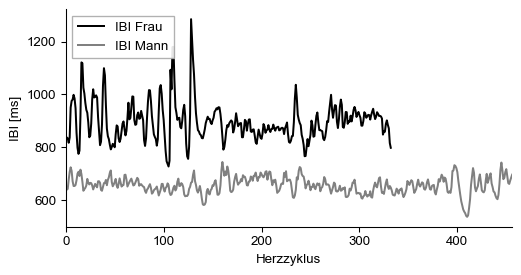

In [85]:
# Plot IBI data #d=0
d=3
fig = plt.figure(figsize=figsize, dpi=dpi)

plt.margins(x=0)

# plt.title("IBI-Werte einer Dyade abhängig zum Herzzyklus")
plt.xlabel('Herzzyklus')
plt.ylabel('IBI [ms]')

plt.plot(ibi[d], color="black", label="IBI Frau")
plt.plot(ibi[d+1], color="grey", label="IBI Mann")
sns.despine()
plt.legend(loc="upper left")

print("Number of R-peaks in plot:", sum(rpeaks[d]), sum(rpeaks[d+1]))
plt.savefig("plots/ibi_dyad.png", dpi=512)

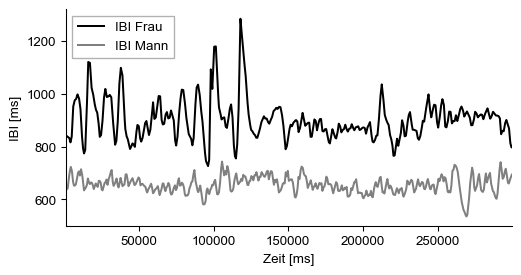

In [86]:
# Plot imputated IBIs #d=0
fig = plt.figure(figsize=figsize, dpi=dpi)

plt.margins(x=0)

# plt.title("Linear interpolierte IBI-Werte einer Dyade abhängig zur Zeit")
plt.xlabel('Zeit [ms]')
plt.ylabel('IBI [ms]')

plt.plot(ibi_ts_ip[d], color="black", label="IBI Frau")
plt.plot(ibi_ts_ip[d+1], color="grey", label="IBI Mann")
sns.despine()
plt.legend(loc="upper left")

plt.savefig("plots/ibi_ts_dyad.png", dpi=512)

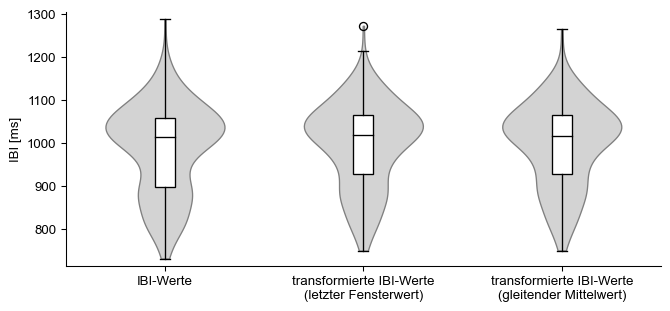

In [87]:
# Create Violin plot 
p = 1
ibi_dataset = {
    "all": [np.array(ibi_all), np.array(ibi_ts_ip_1hz_all), np.array(ibi_ts_ip_win_all)],
    "individual": [np.array(ibi[p]), np.array(ibi_ts_ip_1hz[p].dropna()), np.array(ibi_ts_ip_win[p].dropna())]
}

positions = [1, 2, 3]

# Draw violin plot with box plot
fig, ax = plt.subplots(figsize=[8,3.5], dpi=dpi)

plt.margins(y=0.03)
plt.margins(x=0.0)

# plt.title("Verteilung ursprünglicher und transformierter IBI-Werte einer Person")
plt.ylabel('IBI [ms]')

# Plot individual or all data
vp = ax.violinplot(dataset=ibi_dataset["individual"], positions=positions, vert=True, widths=0.6, showmeans=False, showextrema=False, showmedians=False)
bp = ax.boxplot(ibi_dataset["individual"], positions=positions, widths=0.1, patch_artist=True, medianprops=dict(color="black"))
sns.despine()

plt.xticks(ticks=[1, 2, 3], labels=["IBI-Werte", "transformierte IBI-Werte\n(letzter Fensterwert)", "transformierte IBI-Werte\n(gleitender Mittelwert)"])

for body in vp['bodies']:
    body.set_facecolor('lightgrey')
    body.set_edgecolor('grey')
    body.set_alpha(1)

for box in bp['boxes']:
    box.set(facecolor = 'white' )

plt.savefig("plots/ibi_distribution.png", dpi=512)

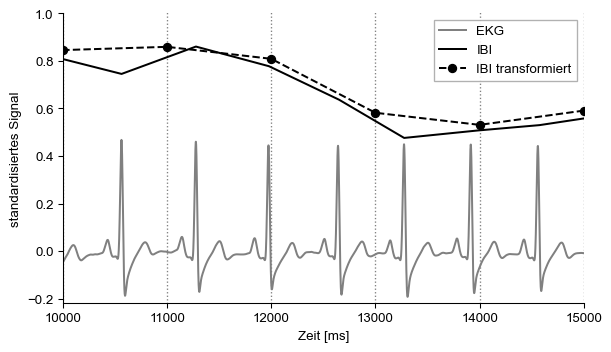

In [88]:
# Plot linear interpolated IBIs
p = 4
# Reminder: plot data with different number of datapoints for IBI and tranformed IBI
fig = plt.figure(figsize=[7,4], dpi=dpi)

# plt.xlim(xlim1, xlim2)
plt.xlim(10000,15000)
plt.ylim(ymax=1, ymin=-0.22)
plt.margins(x=0)

# plt.title("EKG-Signal im Vergleich zu linear interpolierten IBI-Werten")
plt.xlabel('Zeit [ms]')
plt.ylabel('standardisiertes Signal')

# multiple lines all full height
plt.vlines(x=list(range(0, len(rpeaks[0]), 1000)), ymin=-2, ymax=2, colors='grey', ls=':', lw=1)#, label='vline_multiple - full height')
plt.plot(ecg[p], '-', color='grey', label="EKG")
plt.plot(get_normalized_df(ibi_ts_ip[p]), 'k-', label="IBI")
plt.plot(get_normalized_df(ibi_ts_ip_win[p]), 'k--o', label="IBI transformiert")
# plt.plot(get_normalized_df(ibi_ts_ip_1hz[p]), 'k--o', label="transformierte IBI")

sns.despine()
plt.legend(loc="best")

plt.savefig("plots/ecg_ibi.png", dpi=512)

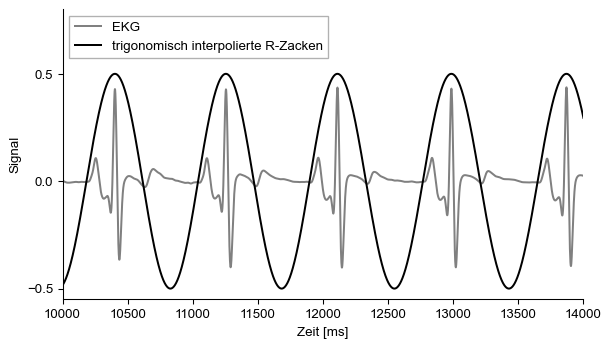

In [89]:
# Plot trigonomic interpolated R-peaks
p = 0
fig = plt.figure(figsize=[7,4], dpi=dpi)

plt.xlim(xlim1, xlim2)
plt.margins(x=0)
plt.ylim(ymax=0.8, ymin=-0.55)
plt.yticks([-0.5,0,0.5])

# plt.title("EKG-Signal im Vergleich zu trigonomisch interpolierten R-Zacken")
plt.xlabel('Zeit [ms]')
plt.ylabel('Signal')

plt.plot(ecg[p], "-", color='grey', label="EKG")
plt.plot(data[p], "k-", label="trigonomisch interpolierte R-Zacken")

sns.despine()
plt.legend(loc="upper left")

plt.savefig("plots/ecg_cos.png", dpi=512)

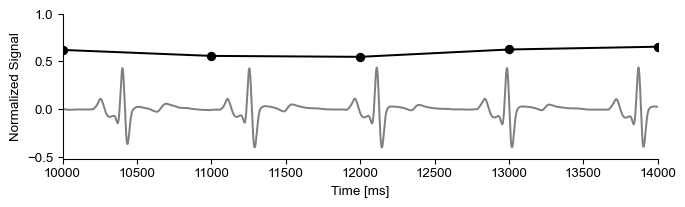

In [92]:
# Plot trigonomic interpolated R-peaks
#english
p = 0
fig = plt.figure(figsize=[8,2], dpi=96)

plt.xlim(xlim1, xlim2)
plt.margins(x=0)
plt.ylim(ymax=1, ymin=-0.52)

# plt.title("EKG-Signal im Vergleich zu trigonomisch interpolierten R-Zacken")
plt.xlabel('Time [ms]')
plt.ylabel('Normalized Signal')

plt.plot(ecg[p], "-", color='grey', label="ECG")
# plt.plot(data[p], "k-", label="trigonometric interpolated IBI")
plt.plot(get_normalized_df(ibi_ts_ip_win[p]), 'k-o', label="transformed IBI")

# plt.plot(get_normalized_df(ibi_ts_ip_win[p]), "k-", label="trigonometric interpolated IBI")

sns.despine()

plt.savefig("plots/ecg_cos.png", dpi=512)

In [91]:
p=7
print(len(ibi[p]),len(ibi_ts_ip_1hz[p]),len(ibi_ts_ip_win[p]))

362 300 300
